# Predictive Maintenance for ESP Pump : Failure Prediction

In this notebook, we are trying to predict ESP pump failure in a well before it happens. Based on historical time series data of already existing pumps, we are going to train and build a deep learning model for prediciton.

## Importing librairies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import visualkeras
plt.rcParams['agg.path.chunksize'] = 10000
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
import seaborn as sns
from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')
clear_output()
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense, Embedding, LSTM, SpatialDropout1D
from keras.layers.convolutional import Conv1D, MaxPooling1D, AveragePooling1D, Conv2D
from sklearn.preprocessing import RobustScaler
from tensorflow.keras import layers

## Loading & Processing Data

In [2]:
data = pd.read_csv("wells_data.csv", parse_dates=True, index_col="Unnamed: 0")
data = data.reset_index(drop=True)

In [3]:
data.describe()

,CURRENT,PRESS_DESC,FREQUENCY,PRESS_INT,TEMP_INT,TEMP_MOT,OUT_VOLT,VIBRATION,BFPD,BOPD,...,BSW,GOR(MSFC/BPPD),GLR(SCF/BFPD),API,FREC(Hz),PIP(PSI),INTAKE_DEPTH,AMPERAGE,WHP(PSI),FAILURE
count,58979.000000,57194.000000,58979.000000,58979.000000,58503.000000,58168.000000,27726.000000,56666.000000,58979.000000,58979.000000,...,58979.000000,58979.000000,58979.000000,58979.000000,58979.000000,58075.000000,58979.000000,58979.000000,58979.000000,58979.000000
mean,34.894016,3162.037101,59.276908,674.075516,228.011368,266.758217,264.853927,0.294852,696.869941,310.084317,...,39.730874,97.704274,60.011508,22.250739,61.604775,494.972312,9611.645366,36.663072,113.594751,0.002119
std,16.541065,1734.936712,24.792601,979.063617,41.387009,51.829133,208.575610,1.811388,637.861865,302.520470,...,31.568172,64.896288,56.206490,5.714801,17.699490,417.350432,514.492850,16.583678,75.641891,0.052850
min,20.000000,0.000000,25.000000,0.000000,175.000000,175.000000,0.000000,0.000000,13.900000,7.300000,...,0.000000,0.000000,0.000000,10.000000,25.000000,0.000000,8000.000000,20.000000,0.500000,0.000000
25%,21.000000,3073.074835,52.000000,240.000000,223.439753,247.100000,0.000000,0.000000,220.000000,138.000000,...,5.000000,55.991627,16.801999,18.000000,54.000000,262.000000,9392.000000,23.000000,50.000000,0.000000
50%,29.000000,3817.672946,56.000000,344.240000,229.140000,278.000000,394.408846,0.000000,456.000000,231.400000,...,38.000000,84.003411,42.560000,19.200000,57.000000,356.000000,9589.000000,31.000000,100.000000,0.000000
75%,44.607595,4056.821263,61.000000,668.973873,235.596872,294.840000,446.305000,0.222373,1020.000000,390.060000,...,70.000000,145.814707,82.331081,27.100000,63.000000,561.000000,9899.000000,48.000000,150.000000,0.000000
max,150.000000,10500.000000,150.000000,5000.000000,500.000000,500.000000,607.540000,20.000000,3866.000000,2425.840000,...,99.000000,300.000000,300.000000,42.000000,150.000000,5000.000000,11850.000000,150.000000,400.000000,2.000000


In [4]:
data.isna().sum()

DATE                  0
WELL_ID               0
CURRENT               0
PRESS_DESC         1785
FREQUENCY             0
PRESS_INT             0
TEMP_INT            476
TEMP_MOT            811
OUT_VOLT          31253
VIBRATION          2313
BFPD                  0
BOPD                  0
BWPD                  0
MSCF                  0
BSW                   0
GOR(MSFC/BPPD)        0
GLR(SCF/BFPD)         0
API                   0
FREC(Hz)              0
PIP(PSI)            904
INTAKE_DEPTH          0
AMPERAGE              0
PUMP                  0
WHP(PSI)              0
FAILURE               0
dtype: int64

In [5]:
data.fillna(method='bfill', inplace=True)
data.isna().sum()

DATE              0
WELL_ID           0
CURRENT           0
PRESS_DESC        0
FREQUENCY         0
PRESS_INT         0
TEMP_INT          0
TEMP_MOT          0
OUT_VOLT          0
VIBRATION         0
BFPD              0
BOPD              0
BWPD              0
MSCF              0
BSW               0
GOR(MSFC/BPPD)    0
GLR(SCF/BFPD)     0
API               0
FREC(Hz)          0
PIP(PSI)          0
INTAKE_DEPTH      0
AMPERAGE          0
PUMP              0
WHP(PSI)          0
FAILURE           0
dtype: int64

In [6]:
nums = np.arange(1,len(data['WELL_ID'].unique())+1)
data_dict = dict(zip(data['WELL_ID'].unique(),nums))
data['WELL_ID'] = data['WELL_ID'].replace(data_dict)
data.head()

,DATE,WELL_ID,CURRENT,PRESS_DESC,FREQUENCY,PRESS_INT,TEMP_INT,TEMP_MOT,OUT_VOLT,VIBRATION,...,GOR(MSFC/BPPD),GLR(SCF/BFPD),API,FREC(Hz),PIP(PSI),INTAKE_DEPTH,AMPERAGE,PUMP,WHP(PSI),FAILURE
0,2019-02-25,1,72.42,4252.87,57.44,1443.97,222.71,281.56,0.0,0.17,...,123.54874,6.177437,18.6,57.5,1453.0,8915.0,72.0,ESP-890,330.0,0
1,2019-02-26,1,72.77,4203.62,57.44,1414.84,222.80,281.09,0.0,0.15,...,123.54874,6.177437,18.6,57.5,1453.0,8915.0,72.0,ESP-890,330.0,0
2,2019-02-27,1,72.29,4271.55,57.45,1449.17,222.72,281.55,0.0,0.15,...,123.54874,6.177437,18.6,57.5,1453.0,8915.0,72.0,ESP-890,330.0,0
3,2019-02-28,1,72.29,4271.55,57.45,1449.17,222.72,281.55,0.0,0.15,...,123.54874,6.177437,18.6,57.5,1453.0,8915.0,72.0,ESP-890,330.0,0
4,2019-03-01,1,72.29,4271.55,57.45,1449.17,222.72,281.55,0.0,0.15,...,123.54874,6.177437,18.6,57.5,1453.0,8915.0,72.0,ESP-890,330.0,0


## Exploring Data

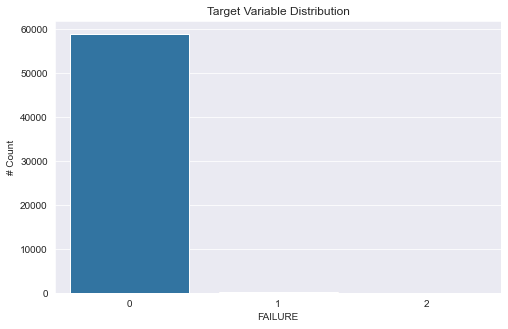

In [74]:
sns.set_style('darkgrid')
plt.figure(figsize=(8, 5))
sns.countplot(data["FAILURE"])
plt.title('Target Variable Distribution')
plt.ylabel('# Count')
plt.show()

## Modeling

In [7]:
from sklearn.utils.class_weight import compute_class_weight  
class_weights = dict(zip(data['FAILURE'].unique(), compute_class_weight(class_weight = "balanced", classes = data['FAILURE'].unique(), y=data['FAILURE'].values)))

### MLP

#### Training

In [54]:
def split_data(data):
    """ 
    Function is used to split data into training and test sets
    Training : 65%
    Validation : 20%
    Test : 15%
    """
    features = list(data.keys().drop(['PUMP','FAILURE','PIP(PSI)','AMPERAGE', 'FREC(Hz)','WHP(PSI)','MSCF','BFPD'])) #,'MSCF','BFPD'
    train_index_value = int(len(data)*0.60)
    train_index = np.arange(0,train_index_value)
    test_index = np.arange(train_index_value,len(data))
    X_train = data.loc[train_index,features]
    X_train = X_train.set_index(['DATE'])
    X_test = data.loc[test_index,features]
    X_test = X_test.set_index(['DATE'])
    X_test_index = X_test.index
    y_train = data.loc[train_index,['DATE','FAILURE']]
    y_test = data.loc[test_index ,['DATE','FAILURE']]
    y_train = y_train.set_index(['DATE'])
    y_test = y_test.set_index(['DATE'])
    #encoder = LabelEncoder()
    #encoder.fit(y_train)
    #encoded_Y = encoder.transform(y_train)
    #y_train = np_utils.to_categorical(encoded_Y)
    X_scaler, y_scaler = MinMaxScaler(), MinMaxScaler() 
    X_train_scaled = X_scaler.fit_transform(X_train)
    X_test_scaled = X_scaler.fit_transform(X_test)
    return X_train_scaled.astype('float32'), y_train, X_test_scaled.astype('float32'), y_test, X_test_index


In [67]:
def train_mlp_model(X_train, y_train, X_test, y_test):

    batch_size = 32
    epochs = 100

    model = Sequential()
    # kernel_regularizer=tf.keras.regularizers.L2(reg))

    model.add(Dense(16, activation='relu',input_shape = (X_train.shape[1],)))
    #model.add(Dropout(0.1))

    model.add(Dense(32, activation='relu'))
    #model.add(Dropout(0.2))

    model.add(Dense(8, activation='relu'))
    model.add(Dropout(0.1))

    model.add(Dense(3, activation='sigmoid'))
    #model.add(Dropout(0.1))

    model.add(Dense(3, activation='softmax'))

    model.compile(loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False), optimizer=tf.optimizers.Adam(), metrics=['accuracy'])
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, class_weight=class_weights,
    use_multiprocessing=True,validation_data=(X_test, y_test)) 

    return model, history
    

In [68]:
X_train, y_train, X_test, y_test,X_test_index = split_data(data)
mlp_model, history = train_mlp_model(X_train, y_train, X_test, y_test)

Epoch 1/100
1106/1106 [==============================] - 7s 6ms/step - loss: 1.2345 - accuracy: 0.7452 - val_loss: 0.9947 - val_accuracy: 0.6974
Epoch 2/100
1106/1106 [==============================] - 7s 6ms/step - loss: 1.2127 - accuracy: 0.4363 - val_loss: 0.7949 - val_accuracy: 0.9386
Epoch 3/100
1106/1106 [==============================] - 7s 6ms/step - loss: 1.1901 - accuracy: 0.5597 - val_loss: 0.9559 - val_accuracy: 0.7662
Epoch 4/100
1106/1106 [==============================] - 7s 6ms/step - loss: 1.1466 - accuracy: 0.4934 - val_loss: 0.8745 - val_accuracy: 0.8919
Epoch 5/100
1106/1106 [==============================] - 7s 6ms/step - loss: 1.1390 - accuracy: 0.5892 - val_loss: 1.0114 - val_accuracy: 0.6540
Epoch 6/100
1106/1106 [==============================] - 7s 7ms/step - loss: 1.1386 - accuracy: 0.3776 - val_loss: 0.8931 - val_accuracy: 0.8254
Epoch 7/100
1106/1106 [==============================] - 7s 6ms/step - loss: 1.1194 - accuracy: 0.6481 - val_loss: 1.0949 - val_ac

In [69]:
mlp_model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_110 (Dense)           (None, 16)                272       
                                                                 
 dense_111 (Dense)           (None, 32)                544       
                                                                 
 dense_112 (Dense)           (None, 8)                 264       
                                                                 
 dropout_29 (Dropout)        (None, 8)                 0         
                                                                 
 dense_113 (Dense)           (None, 3)                 27        
                                                                 
 dense_114 (Dense)           (None, 3)                 12        
                                                                 
Total params: 1,119
Trainable params: 1,119
Non-train

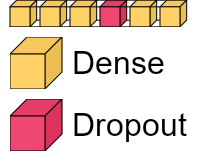

In [70]:
from PIL import ImageFont

font = ImageFont.truetype("arial.ttf", 32)  # using comic sans is strictly prohibited!
visualkeras.layered_view(mlp_model, legend=True, font=font)  # font is optional!

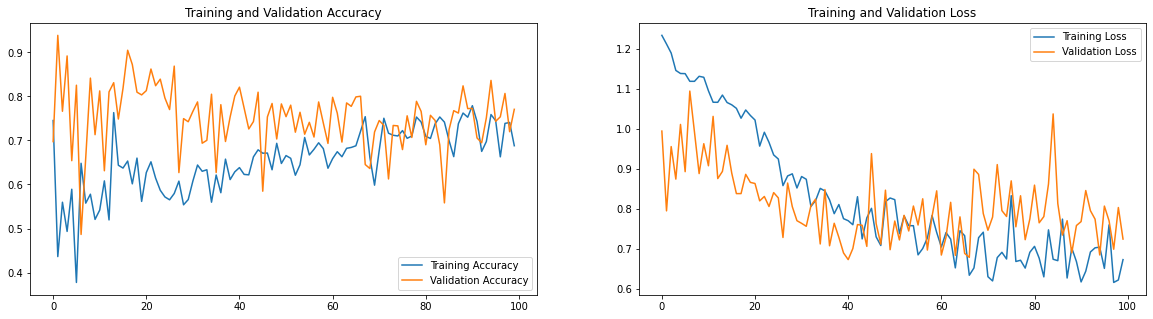

In [71]:
def plot_eval(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(100)
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

plot_eval(history)

In [72]:
# Training Accuracy & Loss
scores = mlp_model.evaluate(X_train, y_train)
print(f'Score: {mlp_model.metrics_names[0]} of {scores[0]}; {mlp_model.metrics_names[1]} of {scores[1]*100}%')

1106/1106 [==============================] - 3s 3ms/step - loss: 0.7650 - accuracy: 0.7838
Score: loss of 0.7650426626205444; accuracy of 78.3790647983551%


In [73]:
# Validation Accuracy & Loss
scores = mlp_model.evaluate(X_test, y_test)
print(f'Score: {mlp_model.metrics_names[0]} of {scores[0]}; {mlp_model.metrics_names[1]} of {scores[1]*100}%')

738/738 [==============================] - 2s 3ms/step - loss: 0.7243 - accuracy: 0.7707
Score: loss of 0.7242580056190491; accuracy of 77.06849575042725%


#### Prediction

In [14]:
prediction = mlp_model.predict(X_test)
prediction = pd.DataFrame(prediction,columns=['Normal','Yes','Manual Off'],index=X_test_index)
prediction = prediction.round().astype(int)
preds = []
for index,row in prediction.iterrows():
  if row["Normal"] == 1:
    preds.append(0)
  elif row["Yes"] == 1:
    preds.append(1)
  else:
    preds.append(2)

y_preds = y_test.copy()
y_preds['FAILURE'] = preds

In [19]:
list(data.keys().drop(['PUMP','FAILURE','PIP(PSI)','AMPERAGE', 'FREC(Hz)','WHP(PSI)','MSCF','BFPD']))

['DATE',
 'WELL_ID',
 'CURRENT',
 'PRESS_DESC',
 'FREQUENCY',
 'PRESS_INT',
 'TEMP_INT',
 'TEMP_MOT',
 'OUT_VOLT',
 'VIBRATION',
 'BOPD',
 'BWPD',
 'BSW',
 'GOR(MSFC/BPPD)',
 'GLR(SCF/BFPD)',
 'API',
 'INTAKE_DEPTH']

In [16]:
y_preds

,FAILURE
DATE,
2021-05-21,0
2021-05-22,0
2021-05-23,0
2021-05-24,0
2021-05-25,0
...,...
2019-11-04,1
2019-11-05,1
2019-11-06,1


In [17]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_preds)

0.6963377416073245

#### Cross-Validation Evaluation

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
tscv = TimeSeriesSplit(n_splits = 4)
accuracies = []
for train_index, test_index in tscv.split(data):
    cv_train, cv_test = data.iloc[train_index], data.iloc[test_index]
    features = list(data.keys().drop(['PUMP','FAILURE','PIP(PSI)','AMPERAGE', 'FREC(Hz)','WHP(PSI)','MSCF','BFPD'])) #,'MSCF','BFPD'

    X_train = cv_train[features]
    y_train = cv_train[['DATE','FAILURE']]
    X_train = X_train.set_index(['DATE'])
    
    X_test = cv_test[features]
    y_test = cv_test[['DATE','FAILURE']]
    X_test = X_test.set_index(['DATE'])
    X_test_index = X_test.index
    
    y_train = y_train.set_index(['DATE'])
    y_test = y_test.set_index(['DATE'])
    X_scaler, y_scaler = MinMaxScaler(), MinMaxScaler() 
    X_train_scaled = X_scaler.fit_transform(X_train)
    X_test_scaled = X_scaler.fit_transform(X_test)
    X_train = X_train_scaled.astype('float32')
    X_test = X_test_scaled.astype('float32')
    model = train_mlp_model(X_train, y_train)
    
    prediction = mlp_model.predict(X_test)
    prediction = pd.DataFrame(prediction,columns=['Normal','Yes','Manual Off'],index=X_test_index)
    prediction = prediction.round().astype(int)
    preds = []
    
    for index,row in prediction.iterrows():
        if row["Normal"] == 1:
            preds.append(0)
        elif row["Yes"] == 1:
            preds.append(1)
        else:
            preds.append(2)





    y_preds = y_test.copy()
    y_preds['FAILURE'] = preds
    accuracies.append(accuracy_score(y_test, y_preds))
    
print("Average Accuracy: {}".format(np.mean(accuracies)))

TypeError: train_mlp_model() missing 2 required positional arguments: 'X_test' and 'y_test'

In [ ]:
print(accuracies)
#Average Accuracy: 0.9098770665536244

[0.8926663840610428, 0.884272997032641, 0.9220856295040272, 0.9404832556167868]


#### Saving MLP Model

In [ ]:
mlp_model.save('mlp_model_weights.h5')